In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

from graph_embedding_continuity import wasserstein_metric

In node2vec, the random walk on the graph to generate word sequences is weighted by two parameters $p$ and $q$ to control breadth-first vs depth-first sampling. More precisely let $(W_t)$ denote the random walk, then the transition probability from a vertex $W_t=v$ to $W_{t+1}=x$ are proportional to the adjacency weights adjusted by :
$$
\begin{cases} 
    \frac{1}{p} \text{  if $W_{t-1}$ = x,} \\
    1 \text{ if \{$W_{t-1}, x, v$\} is a triangle,} \\
    \frac{1}{q} \text{ otherwise.} \\
\end{cases}
$$

In particular, $(W_t)$ is not a Markovian walk since it depends on the prior step. This obstacle is easy to alleviate though as $(W_{t-1}, W_t)$ is Markovian, at the expense of a larger state space.

In what follows, we study the invariant distribution of this induced 2-step chain as a function of $p$ and $q$. 

Recall that invariant distribution $\pi$ is defined, when it exists (which is the case for an ergodic chain such as this one), as the normalized left-eigenvector of the transition matrix $P$ associated with eigenvalue $1$. One can either compute the spectral decomposition of $P^\top$ numerically or solve analytically the 8x8 linear system $(P^\top - Id) \pi = 0$.

### Draw graph and its 2-step Markov chain

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


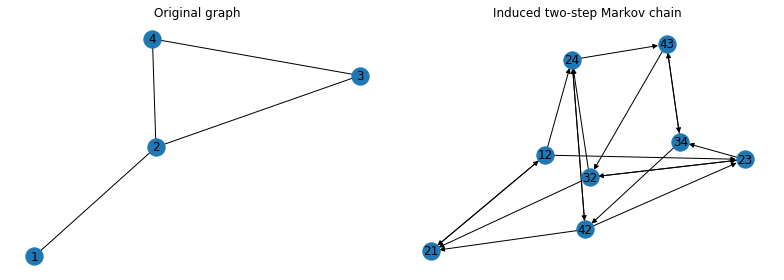

In [2]:
G1, G2 = nx.Graph(), nx.DiGraph()

G1.add_nodes_from([1, 2, 3, 4])

G1.add_edge(1,2)
G1.add_edge(2,3)
G1.add_edge(2,4)
G1.add_edge(3,4)


G2.add_nodes_from([12, 21, 23, 32, 34, 43, 24, 42 ])

G2.add_edge(12, 21)
G2.add_edge(12, 23)
G2.add_edge(12, 24)
G2.add_edge(21, 12)
G2.add_edge(23, 32)
G2.add_edge(23, 34)
G2.add_edge(32, 21)
G2.add_edge(32, 23)
G2.add_edge(32, 24)
G2.add_edge(34, 43)
G2.add_edge(34, 42)
G2.add_edge(43, 32)
G2.add_edge(43, 34)
G2.add_edge(24, 43)
G2.add_edge(24, 42)
G2.add_edge(42, 21)
G2.add_edge(42, 23)
G2.add_edge(42, 24)

fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=2)

ax = axes[0]
nx.draw_networkx(G1, ax=ax)
ax.axis('off')
ax.set_title('Original graph')

ax = axes[1]
nx.draw_networkx(G2, ax=ax)
ax.axis('off')
ax.set_title('Induced two-step Markov chain')

plt.tight_layout()
plt.show()

fig.savefig('4_nodes_graph.eps')

### Numerical solution

In [3]:
def numerical_invariant_distr(P):
    e, U = np.linalg.eig(P.T)
    e = np.real(e)
    U = np.real(U)

    # find index of eigenvalue 1
    idx = np.where(np.abs(e-1)<1e-8)
    u = U[:, idx]
    u /= np.sum(u)
    
    return u.flatten()

### Analytical solution (node2vec)

In [4]:
cond = np.zeros((4,8))
cond[0, 1] = 1
cond[1, 0] = 1
cond[1, 3] = 1
cond[1, 7] = 1
cond[2, 2] = 1
cond[2, 5] = 1
cond[3, 4] = 1
cond[3, 6] = 1

def invariant_measure(p, q):
    x = ((p+1)*q+p)/(q+2*p)
    pi = np.array([1, 1, x, x, x, x, x, x])
    pi /= np.sum(pi)

    return np.dot(cond, pi)

### Standard random walk

In [5]:
P_standard = np.array([
    [0, 1, 0, 0], 
    [1/3, 0, 1/3, 1/3],
    [0, 1/2, 0, 1/2],
    [0, 1/2, 1/2, 0],
])

# numerical solution
pi_num = numerical_invariant_distr(P_standard)

# analytic solution
pi_standard = np.array([1, 3, 2, 2])/8

assert np.linalg.norm(pi_num-pi_standard) < 1e-12

### node2vec - breadth-first incentive

In [6]:
p = 0.1
q = 10.0

# normalization constant
a = 1/(1/p+2/q)
b = 1/(1+1/p)
c = 1/(1+1/p+1/q)

P = np.array([
    [0, a/p, a/q, 0, 0, 0, a/q, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, b/p, b, 0, 0, 0],
    [0, c/q, c/p, 0, 0, 0, c, 0],
    [0, 0, 0, 0, 0, b/p, 0, b],
    [0, 0, 0, b, b/p, 0, 0, 0],
    [0, 0, 0, 0, 0, b, 0, b/p],
    [0, c/q, c, 0, 0, 0, c/p, 0]
])
    
# numerical solution
pi_num = numerical_invariant_distr(P)

# analytical solution
x = ((p+1)*q+p)/(q+2*p)
pi = [1, 1, x, x, x, x, x, x]
pi /= np.sum(pi)

assert np.linalg.norm(pi_num-pi) < 1e-12

# recover the long-term steady state by summing the conditional probabilities
pi_bf = np.dot(cond, pi)

In [7]:
pi_bf

array([0.11724138, 0.37241379, 0.25517241, 0.25517241])

### node2vec - depth-first incentive

In [8]:
p = 10.0
q = 0.1

# normalization constant
a = 1/(1/p+2/q)
b = 1/(1+1/p)
c = 1/(1+1/p+1/q)

P = np.array([
    [0, a/p, a/q, 0, 0, 0, a/q, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, b/p, b, 0, 0, 0],
    [0, c/q, c/p, 0, 0, 0, c, 0],
    [0, 0, 0, 0, 0, b/p, 0, b],
    [0, 0, 0, b, b/p, 0, 0, 0],
    [0, 0, 0, 0, 0, b, 0, b/p],
    [0, c/q, c, 0, 0, 0, c/p, 0]
])
    
# numerical solution
pi_num = numerical_invariant_distr(P)

# analytical solution
x = ((p+1)*q+p)/(q+2*p)
pi = [1, 1, x, x, x, x, x, x]
pi /= np.sum(pi)

assert np.linalg.norm(pi_num-pi) < 1e-12

# recover the long-term steady state by summing the conditional probabilities
pi_df = np.dot(cond, pi)

### Compare

Breadth-first sampling gives more weight to clique (2,3,4) while depth-first sampling explores more the isolated node 1.

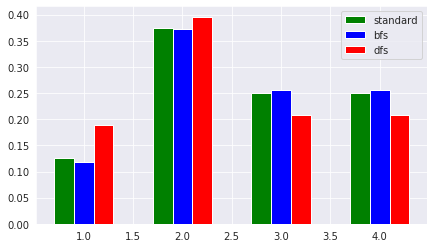

In [9]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7,4), nrows=1, ncols=1)
    x = np.array([1,2,3,4])
    ax.bar(x-0.2, pi_standard, label='standard', color='g', width=0.2)
    ax.bar(x, pi_bf, label='bfs', color='b', width=0.2)
    ax.bar(x+0.2, pi_df, label='dfs', color='r', width=0.2)
    ax.legend(loc='upper right')

## Distance with invariant measures under edge removal

In [10]:
pi_12 = np.array([0, 1/3, 1/3, 1/3]) # triangle
pi_23 = np.array([1/6, 1/3, 1/3, 1/6]) # chain
pi_34 = np.array([1/6, 1/2, 1/6, 1/6]) # tripod

pp = np.arange(0.1, 10, 0.25)
qq = np.arange(0.1, 10, 0.25)

dd_12_l2 = np.empty((pp.shape[0], qq.shape[0]))
dd_23_l2 = np.empty((pp.shape[0], qq.shape[0]))
dd_34_l2 = np.empty((pp.shape[0], qq.shape[0]))

dd_12_wass = np.empty((pp.shape[0], qq.shape[0]))
dd_23_wass = np.empty((pp.shape[0], qq.shape[0]))
dd_34_wass = np.empty((pp.shape[0], qq.shape[0]))

for i, p in enumerate(pp):
    for j, q in enumerate(qq):
        dd_12_l2[i, j] = np.linalg.norm(invariant_measure(p, q) - pi_12)
        dd_23_l2[i, j] = np.linalg.norm(invariant_measure(p, q) - pi_23)
        dd_34_l2[i, j] = np.linalg.norm(invariant_measure(p, q) - pi_34)
        
        dd_12_wass[i, j] = wasserstein_metric(invariant_measure(p, q), pi_12)
        dd_23_wass[i, j] = wasserstein_metric(invariant_measure(p, q), pi_23)
        dd_34_wass[i, j] = wasserstein_metric(invariant_measure(p, q), pi_34)
        
        
dd_avg_l2 = 1/4*dd_12_l2 + 1/2*dd_23_l2 + 1/4*dd_34_l2
dd_avg_wass = 1/4*dd_12_wass + 1/2*dd_23_wass + 1/4*dd_34_wass
        
pp, qq = np.meshgrid(pp, qq)

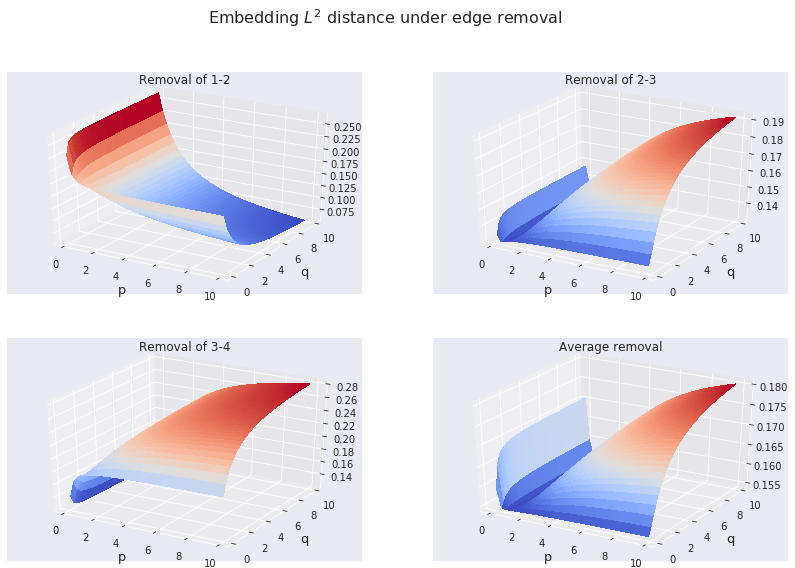

In [11]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(14, 9))
    
    fig.suptitle('Embedding $L^2$ distance under edge removal', fontsize=16)

    ax = fig.add_subplot(221, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Removal of 1-2')
    surf = ax.plot_surface(pp, qq, dd_12_l2, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax = fig.add_subplot(222, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Removal of 2-3')
    surf = ax.plot_surface(pp, qq, dd_23_l2, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax = fig.add_subplot(223, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Removal of 3-4')
    surf = ax.plot_surface(pp, qq, dd_34_l2, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax = fig.add_subplot(224, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Average removal')
    surf = ax.plot_surface(pp, qq, dd_avg_l2, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    plt.show()
    
    fig.savefig('4_nodes_emb_dist_l2.eps')    

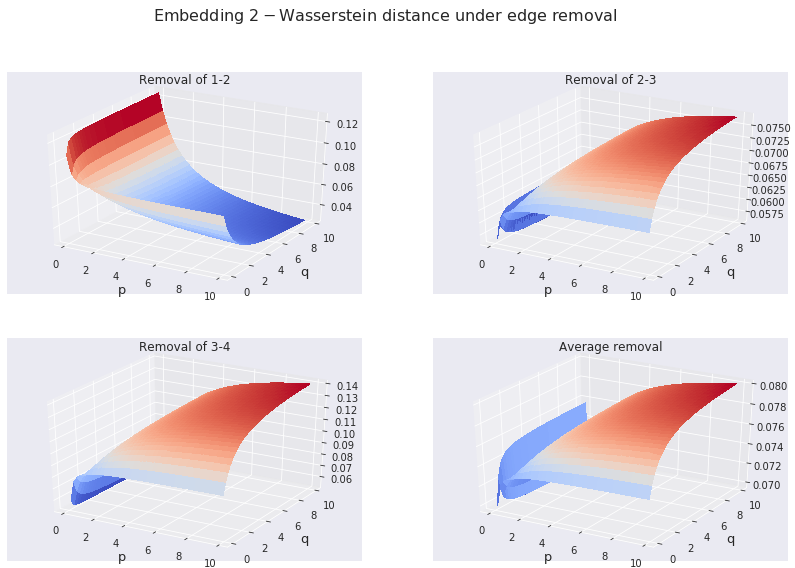

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(14, 9))
    
    fig.suptitle('Embedding $2-$Wasserstein distance under edge removal', fontsize=16)

    ax = fig.add_subplot(221, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Removal of 1-2')
    surf = ax.plot_surface(pp, qq, dd_12_wass, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax = fig.add_subplot(222, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Removal of 2-3')
    surf = ax.plot_surface(pp, qq, dd_23_wass, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax = fig.add_subplot(223, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Removal of 3-4')
    surf = ax.plot_surface(pp, qq, dd_34_wass, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax = fig.add_subplot(224, projection='3d')
    ax.set_xlabel('p', fontsize=13)
    ax.set_ylabel('q', fontsize=13)
    ax.set_title('Average removal')
    surf = ax.plot_surface(pp, qq, dd_avg_wass, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    plt.show()
    
    fig.savefig('4_nodes_emb_dist_wass.eps')    